In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.preprocessing import StandardScaler

# Constants
import constants

class data_loader:
    def __init__(self, dataset_name, batch_size):
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.paths = constants.IN_DATA_PATHS[dataset_name]
        self.train_columns = None  # Store train columns for alignment

    def drop_index_col(self, df):
        if "Unnamed: 0" in df.columns:
            df.drop("Unnamed: 0", axis=1, inplace=True)
        return df
    
    def load_train_augment_data(self, train_option, augment_option):
        if train_option not in ['original', 'synthetic', 'mix'] or augment_option not in [None, 'ctgan', 'categorical', 'gaussian']:
            raise ValueError("Invalid train_option or augment_option")
        if train_option == 'original':
            train_df = pd.read_csv(self.paths['train_original'])
            train_df = self.drop_index_col(train_df)
        elif train_option == 'synthetic':
            train_df = pd.read_csv(self.paths[train_option][augment_option])
            train_df = self.drop_index_col(train_df)
        else:  # 'mix' option
            original_df = pd.read_csv(self.paths['train_original'])
            original_df = self.drop_index_col(original_df)
            print(self.paths)
            print(self.paths['synthetic'])
            print(self.paths['synthetic'][augment_option])

            synthetic_df = pd.read_csv(self.paths['synthetic'][augment_option])
            synthetic_df = self.drop_index_col(synthetic_df)


            train_df = pd.concat([original_df, synthetic_df], axis=0)
        
        # sort train and test alphabetically so the columns are in the same order
        train_df = train_df.reindex(sorted(train_df.columns), axis=1)
        # print(f"Train dataset columns:\n{train_df.columns}")
        self.train_columns = train_df.columns  # Store columns for test data alignment
        return self._load_data_in_batches(train_df)
        
    def load_test_data(self):
        # Load test data
        print("\n\n path", self.paths['test'])
        test_df = pd.read_csv(self.paths['test'])
        # print(f"Test dataset preview:\n{test_df.head()}")  # Debugging
        print(test_df.head(2))


        if self.train_columns is None:
            raise ValueError("Training data must be loaded before test data to align columns.")

        # Align test columns with training columns
        missing_cols = set(self.train_columns) - set(test_df.columns)
        print(missing_cols)
        for col in missing_cols:
            test_df[col] = 0  
            # sort train and test alphabetically so the columns are in the same order
            test_df = test_df.reindex(sorted(test_df.columns), axis=1)
        
        # Drop extra columns
        extra_cols = set(test_df.columns) - set(self.train_columns)
        
        if extra_cols:
            test_df = test_df.drop(columns=extra_cols)

        # print(f"Test dataset columns after alignment:\n{test_df.columns}")
        # print(f"Test dataset shape after alignment: {test_df.shape}")
            
        
        

        y = test_df[self.paths['target_name']]
        X = test_df.drop(self.paths['target_name'], axis=1)

        print("\n\n y dataloader", y.unique())



        # Standardize features
        X = self._standardize(X)

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X.values, dtype=torch.float)
        y_tensor = torch.tensor(y.values, dtype=torch.float)

        # Create TensorDataset
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

    def _load_data_in_batches(self, df):
        

        y = df[self.paths['target_name']]
        X = df.drop(self.paths['target_name'], axis=1)
        X = self._standardize(X)
        return self._distribute_in_batches(X.values, y.values)
        
    def _standardize(self, df):
        scaler = StandardScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        
    def _distribute_in_batches(self, X, y):
        print("Type X", type(X))
        print("Type y", type(y))
        print("Shape 0 X", len(X))
        print("Shape 1 X", len(X[0]))
        
        num_batch = int(len(X) / self.batch_size)
        batches = []

        for i in range(num_batch):
            start = i * self.batch_size
            end = start + self.batch_size

            batch_X = torch.tensor(X[start:end], dtype=torch.float)
            batch_y = torch.tensor(y[start:end], dtype=torch.float)

            batch = TensorDataset(batch_X, batch_y)
            batches.append(batch)
        
        return DataLoader(ConcatDataset(batches), batch_size=self.batch_size)

In [3]:
data_loader = data_loader('adult', 64)
train_data = data_loader.load_train_augment_data('original', 'ctgan')
test_data = data_loader.load_test_data()

Type X <class 'numpy.ndarray'>
Type y <class 'numpy.ndarray'>
Shape 0 X 38095
Shape 1 X 108


 path ../../data/adult/onehot_adult_test.csv
   capital-loss  education-num  age  capital-gain  hours-per-week  fnlwgt  \
0             0              9   30             0              40  378009   
1             0             12   54             0              39   55861   

   workclass_Private  workclass_State-gov  workclass_?  workclass_Local-gov  \
0                0.0                  0.0          0.0                  0.0   
1                0.0                  0.0          0.0                  0.0   

   ...  native-country_France  native-country_Peru  native-country_Hong  \
0  ...                    0.0                  0.0                  0.0   
1  ...                    0.0                  0.0                  0.0   

   native-country_Columbia  native-country_Yugoslavia  \
0                      0.0                        0.0   
1                      0.0                        0

In [22]:
for data in train_data:
    print(data)
    break


[tensor([[-0.1208, -0.1451, -0.2166,  ..., -0.0126, -0.2665, -0.2053],
        [ 1.2833, -0.1451,  3.8875,  ..., -0.0126, -0.2665, -0.2053],
        [ 1.0616, -0.1451, -0.2166,  ..., -0.0126, -0.2665, -0.2053],
        ...,
        [-0.9336, -0.1451, -0.2166,  ..., -0.0126, -0.2665, -0.2053],
        [ 0.7660, -0.1451, -0.2166,  ..., -0.0126, -0.2665, -0.2053],
        [ 0.0270, -0.1451, -0.2166,  ..., -0.0126, -0.2665, -0.2053]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 0.])]


In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np

# Custom F1 score metric
def f1_score(y_true, y_pred):
    # Convert probabilities to binary (0 or 1) predictions
    y_pred = K.round(y_pred)
    
    # Compute true positives, false positives, and false negatives
    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'))
    
    # Precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # F1 score
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

# Extract feature dimension from a single batch
for X_batch, y_batch in train_data:
    input_dim = X_batch.shape[1]  # Get the number of features
    break

# Convert DataLoader to numpy arrays for Keras
def dataloader_to_numpy(dataloader):
    X_list, y_list = [], []
    for X_batch, y_batch in dataloader:
        X_list.append(X_batch.numpy())  # Convert features to numpy
        y_list.append(y_batch.numpy())  # Convert labels to numpy
    return np.vstack(X_list), np.hstack(y_list)

# Convert training and testing data
X_train, y_train = dataloader_to_numpy(train_data)
X_test, y_test = dataloader_to_numpy(test_data)

# Compute class weights manually
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    num_classes = len(classes)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
    return class_weights

# Compute weights for training labels
y_train_np = y_train.astype(int)  # Ensure labels are integers
class_weight_dict = compute_class_weights(y_train_np)
print("Computed Class Weights:", class_weight_dict)

# Define the model
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Train the model with computed class weights
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict  # Apply computed class weights
)

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {results[1]:.4f}, Test F1 Score: {results[2]:.4f}")



Computed Class Weights: {0: 0.6598052465606266, 1: 2.064404206874119}
Epoch 1/10


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


595/595 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7757 - f1_score: 0.2924 - loss: 0.4369 - val_accuracy: 0.7206 - val_f1_score: 0.2560 - val_loss: 0.5303
Epoch 2/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8084 - f1_score: 0.2878 - loss: 0.3700 - val_accuracy: 0.7359 - val_f1_score: 0.2536 - val_loss: 0.5145
Epoch 3/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8082 - f1_score: 0.2889 - loss: 0.3692 - val_accuracy: 0.7552 - val_f1_score: 0.2361 - val_loss: 0.5031
Epoch 4/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8131 - f1_score: 0.2879 - loss: 0.3621 - val_accuracy: 0.7550 - val_f1_score: 0.2332 - val_loss: 0.5047
Epoch 5/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8167 - f1_score: 0.2889 - loss: 0.3553 - val_accuracy: 0.7571 - val_f1_score: 0.2258 - val_loss: 0.5068
Epoch 6/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8221 - f1_score: 0.2894 - loss: 0.3402 - val_accuracy: 0.7481 - val_f1_score: 0.2379 - val_loss

In [46]:
from sklearn.metrics import f1_score

preds_test = model.predict(X_test)
preds_test_binary = np.round(preds_test)
# print("Preds_binary", preds_test_binary)
f1_test = f1_score(y_test, preds_test_binary)
print("Test F1 Score:", f1_test)

preds_train = model.predict(X_train)
preds_train_binary = np.round(preds_train)
# print("Preds_binary", preds_test_binary)
f1_train = f1_score(y_train, preds_train_binary)
print("Test F1 Score:", f1_train)

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test F1 Score: 0.4846237731733915
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test F1 Score: 0.7138810198300283


In [49]:
print(len(y_train), sum(y_train))
print(len(y_test), sum(y_test))

38080 9223.0
9526 2309.0


## load straigth from csv

In [253]:
df_train = pd.read_csv("D:\\SummerResearch\data\\adult\onehot_adult_train.csv")
df_test = pd.read_csv("D:\\SummerResearch\data\\adult\onehot_adult_test.csv")

print(df_train.shape)
print(df_test.shape)
print("before adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))
# Add missing columns to df_test
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0

# Ensure the columns are in the same order
df_test = df_test[df_train.columns]


print("after adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))


# Sort columns of train and test dataframes alphabetically
df_train = df_train.reindex(sorted(df_train.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)

print("Columns sorted alphabetically")
for i in range(len(df_train.columns)):
    if df_train.columns[i] != df_test.columns[i]:
        print("column difference")
        print(df_train.columns[i], df_test.columns[i])

(38095, 109)
(9526, 108)
before adding
train - test {'native-country_Holand-Netherlands'}
test - train set()
after adding
train - test set()
test - train set()
Columns sorted alphabetically


In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Extract features and target from df_train and df_test
X_train = df_train.drop(columns=['income']).values
y_train = df_train['income'].values
X_test = df_test.drop(columns=['income']).values
y_test = df_test['income'].values

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=256, validation_data=(X_test, y_test))

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {results[1]:.4f}")

Epoch 1/15


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8039 - loss: 0.4003 - val_accuracy: 0.7334 - val_loss: 0.5689
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8497 - loss: 0.3187 - val_accuracy: 0.5175 - val_loss: 0.8293
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8545 - loss: 0.3101 - val_accuracy: 0.6511 - val_loss: 0.6533
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8598 - loss: 0.3025 - val_accuracy: 0.7515 - val_loss: 0.5651
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8593 - loss: 0.2965 - val_accuracy: 0.7643 - val_loss: 0.5407
Epoch 6/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8607 - loss: 0.2946 - val_accuracy: 0.7251 - val_loss: 0.6399
Epoch 7/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8646 - loss: 0.2902 - val_accuracy: 0.7557 - val_loss: 0.5837
Epoch 8/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8672 - loss: 0.2831 - val_accuracy: 0.7616 - 

In [68]:
from sklearn.metrics import f1_score

preds_test = model.predict(X_test)
preds_test_binary = np.round(preds_test)
# print("Preds_binary", preds_test_binary)
f1_test = f1_score(y_test, preds_test_binary)
print("Test F1 Score:", f1_test)

preds_train = model.predict(X_train)
preds_train_binary = np.round(preds_train)
# print("Preds_binary", preds_test_binary)
f1_train = f1_score(y_train, preds_train_binary)
print("Test F1 Score:", f1_train)

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test F1 Score: 0.5289757412398922
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test F1 Score: 0.7386987501460109


## try another dnn

In [176]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Extract features and target from df_train and df_test
# Set random seed for consistent results
np.random.seed(42)
tf.random.set_seed(42)

X_train = df_train.drop(columns=['income']).values
y_train = df_train['income'].values
X_test = df_test.drop(columns=['income']).values
y_test = df_test['income'].values

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




# Define the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
# model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compute class weights manually
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    num_classes = len(classes)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
    return class_weights

# Compute weights for training labels
y_train_np = y_train.astype(int)  # Ensure labels are integers
class_weight_dict = compute_class_weights(y_train_np)
print("original Computed Class Weights:", class_weight_dict)
# class_weight_dict = {0: 0.4, 1: 5}
class_weight_dict = {0: 0.5, 1: 2.5}

print("custom Computed Class Weights:", class_weight_dict)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['precision', 'recall'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])
# history = model.fit(X_test, y_test, epochs=100, batch_size=256, validation_data=(X_train, y_train), class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {results[1]:.4f}")

original Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
custom Computed Class Weights: {0: 0.5, 1: 2.5}
Epoch 1/100


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6219 - precision: 0.3277 - recall: 0.7708 - val_loss: 0.7875 - val_precision: 0.3829 - val_recall: 0.8246
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4225 - precision: 0.4646 - recall: 0.9126 - val_loss: 0.7843 - val_precision: 0.3720 - val_recall: 0.8463
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3922 - precision: 0.4800 - recall: 0.9228 - val_loss: 0.6804 - val_precision: 0.3760 - val_recall: 0.8454
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3831 - precision: 0.4896 - recall: 0.9241 - val_loss: 0.6748 - val_precision: 0.3617 - val_recall: 0.8428
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3749 - precision: 0.4935 - recall: 0.9299 - val_loss: 0.6601 - val_precision: 0.4018 - val_recall: 0.8350
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3641 - precision: 0.4970 - recall: 0.9268 - val_loss: 0.7628 - val_precision: 0.3887 - val_recall: 0.843

In [177]:
from sklearn.metrics import f1_score

preds_test = model.predict(X_test)
preds_test_binary = np.round(preds_test)
# print("Preds_binary", preds_test_binary)
f1_test = f1_score(y_test, preds_test_binary)
print("Test F1 Score:", f1_test)

preds_train = model.predict(X_train)
preds_train_binary = np.round(preds_train)
# print("Preds_binary", preds_test_binary)
f1_train = f1_score(y_train, preds_train_binary)
print("Train F1 Score:", f1_train)

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test F1 Score: 0.5515009886751753
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Train F1 Score: 0.6949396434567112


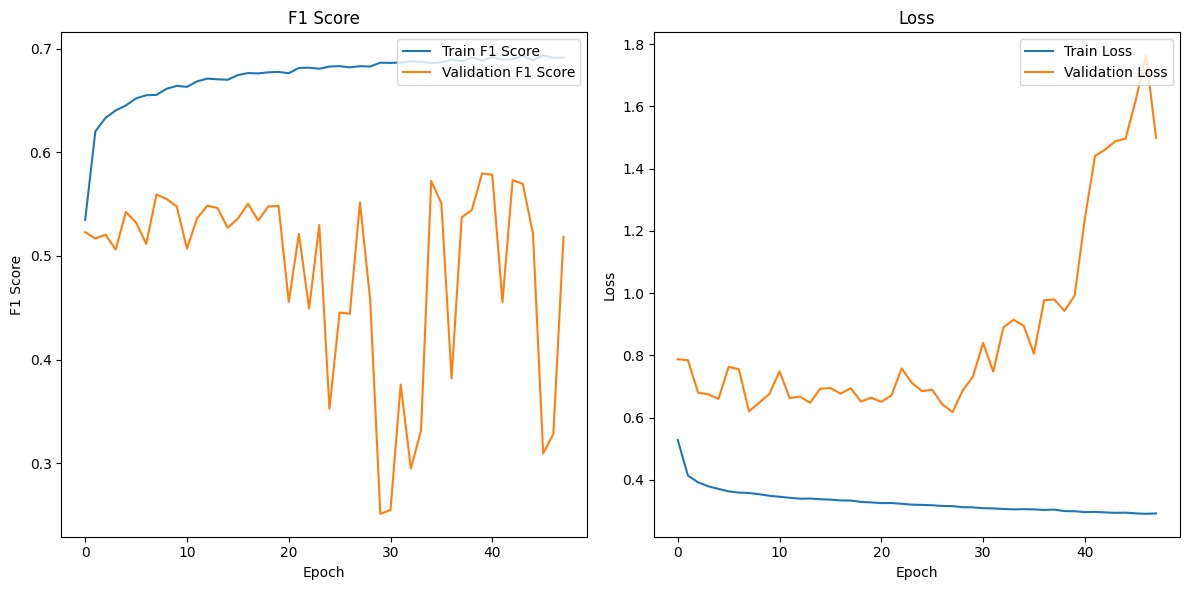

In [179]:
# Compute F1 score from precision and recall for each epoch
precision = np.array(history.history['precision'])
recall = np.array(history.history['recall'])
f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
# Compute F1 score for validation data
precision_val = np.array(history.history['val_precision'])
recall_val = np.array(history.history['val_recall'])
f1_scores_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + K.epsilon())

# Plot F1 scores and loss for training and validation
plt.figure(figsize=(12, 6))

# F1 Score subplot
plt.subplot(1, 2, 1)
plt.plot(f1_scores, label='Train F1 Score')
plt.plot(f1_scores_val, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper right')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

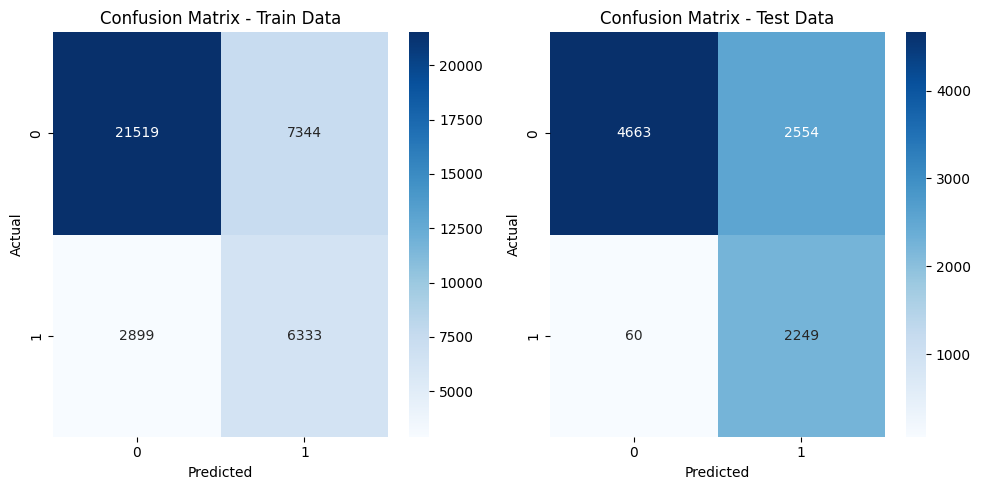

In [175]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute confusion matrix for train data
cm_train = confusion_matrix(y_train, preds_train_binary)
# Compute confusion matrix for test data
cm_test = confusion_matrix(y_test, preds_test_binary)

# Plot confusion matrix for train data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot confusion matrix for test data
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## load straigth from internet

In [1]:
from ucimlrepo import fetch_ucirepo
def load_dataset(dataset_id, verbose=False):
    # fetch dataset
    dataset = fetch_ucirepo(id=dataset_id)

    # data (as pandas dataframes)
    X = dataset.data.features
    y = dataset.data.targets

    if verbose:
        # metadata
        print(dataset.metadata)
        # variable information
        print(dataset.variables)

    return X, y

def load_adult(verbose=False):
    x, y = load_dataset(2, verbose)
    # print(y.income.unique())
    # the y values are "<=50K", "<=50K."", "">50K", ">50K."
    # We need to remove the '.' from the values
    y['income'] = y['income'].str.replace('.', '', regex=False)

    return x, y

In [2]:
X, y = load_adult()


KeyboardInterrupt: 

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Combine X and y
data = X.join(y)

# Drop rows with missing values
data = data.dropna()

# Separate X and y
X = data.drop(columns=['income'])
y = data[['income']]

# Step 1: Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y['income'])

# Display mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:", label_mapping)

# Step 2: Combine X and y (if necessary)
# Since X and y are separate DataFrames, and indices should align, we can proceed directly.

# Step 3: Perform the train-test split
X_train_net, X_test_net, y_train_net, y_test_net = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 4: Verify the split
print("Shapes:")
print("X_train:", X_train_net.shape)
print("X_test:", X_test_net.shape)
print("y_train:", y_train_net.shape)
print("y_test:", y_test_net.shape)

# Check the distribution of the target variable in the splits

print("\nTarget variable distribution:")
print("y_train distribution:", np.bincount(y_train_net))
print("y_test distribution:", np.bincount(y_test_net))

Label Encoding Mapping: {'<=50K': 0, '>50K': 1}
Shapes:
X_train: (38096, 14)
X_test: (9525, 14)
y_train: (38096,)
y_test: (9525,)

Target variable distribution:
y_train distribution: [28863  9233]
y_test distribution: [7217 2308]


In [ ]:
import pandas as pd

# List of categorical variables
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']

# One-hot encode categorical variables in the training set
X_train_encoded = pd.get_dummies(X_train_net, columns=categorical_vars)

# One-hot encode categorical variables in the test set
X_test_encoded = pd.get_dummies(X_test_net, columns=categorical_vars)

# Ensure that both training and test sets have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)



In [219]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Set random seed for consistent results
X_train_net = X_train_encoded
X_test_net = X_test_encoded
np.random.seed(42)
tf.random.set_seed(42)

# Normalize the features
scaler = StandardScaler()
X_train_net = scaler.fit_transform(X_train_net)
X_test_net = scaler.transform(X_test_net)



# Define the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train_net.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compute class weights manually
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    num_classes = len(classes)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
    return class_weights

# Compute weights for training labels
class_weight_dict = compute_class_weights(y_train_net)
print("Computed Class Weights:", class_weight_dict)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['precision', 'recall'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_net, y_train_net, epochs=100, batch_size=256, validation_data=(X_test_net, y_test_net), class_weight=class_weight_dict, callbacks=[early_stopping])


# Evaluate the model
results = model.evaluate(X_test_net, y_test_net, verbose=0)
print(f"Test Accuracy: {results[1]:.4f}")

Computed Class Weights: {0: 0.6599452586356235, 1: 2.063034766598072}
Epoch 1/100


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6290 - precision: 0.3684 - recall: 0.6622 - val_loss: 0.4084 - val_precision: 0.5209 - val_recall: 0.8679
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4448 - precision: 0.5198 - recall: 0.8616 - val_loss: 0.4013 - val_precision: 0.5276 - val_recall: 0.8726
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4154 - precision: 0.5406 - recall: 0.8705 - val_loss: 0.3899 - val_precision: 0.5490 - val_recall: 0.8514
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4041 - precision: 0.5519 - recall: 0.8602 - val_loss: 0.3886 - val_precision: 0.5462 - val_recall: 0.8679
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3919 - precision: 0.5560 - recall: 0.8703 - val_loss: 0.3839 - val_precision: 0.5575 - val_recall: 0.8492
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3874 - precision: 0.5633 - recall: 0.8652 - val_loss: 0.3818 - val_precision: 0.5597 - val_recall: 0.85

best f1 train 0.7181533787788072
best f1 val 0.5814132832518035


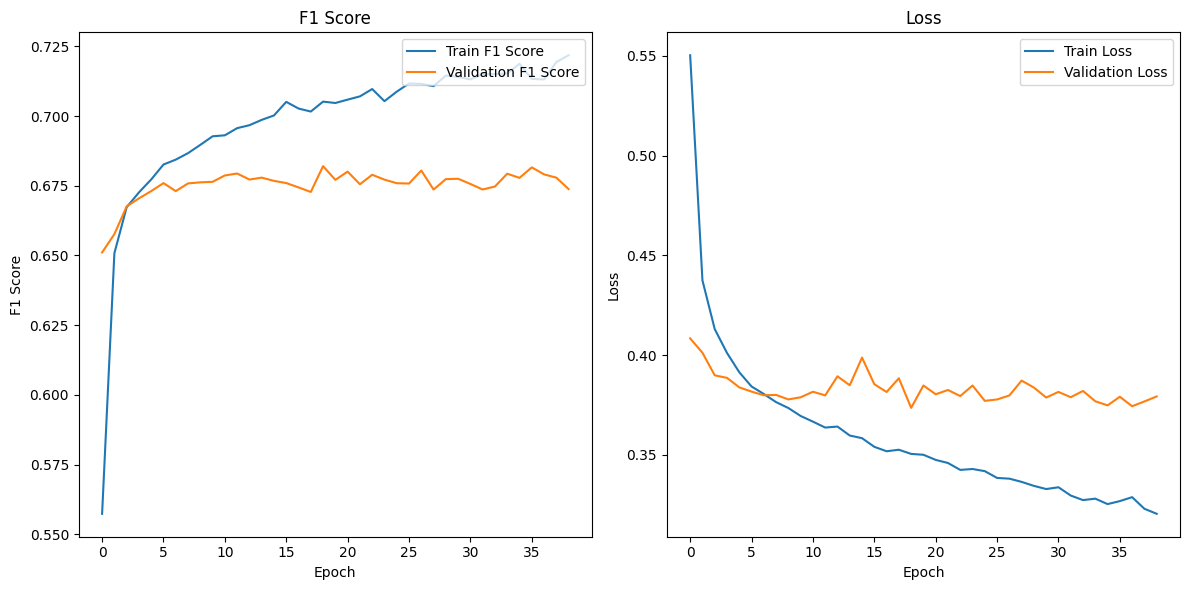

In [220]:
print("best f1 train", max(f1_scores))
print("best f1 val", max(f1_scores_val))

# Compute F1 score from precision and recall for each epoch
precision = np.array(history.history['precision'])
recall = np.array(history.history['recall'])
f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
# Compute F1 score for validation data
precision_val = np.array(history.history['val_precision'])
recall_val = np.array(history.history['val_recall'])
f1_scores_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + K.epsilon())

# Plot F1 scores and loss for training and validation
plt.figure(figsize=(12, 6))

# F1 Score subplot
plt.subplot(1, 2, 1)
plt.plot(f1_scores, label='Train F1 Score')
plt.plot(f1_scores_val, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper right')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



## import not onehot 

In [212]:
df_train = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_train.csv")
df_test = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_test.csv")


# List of categorical variables
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# One-hot encode categorical variables in the training set
df_train_encoded = pd.get_dummies(df_train, columns=categorical_vars)

# One-hot encode categorical variables in the test set
df_test_encoded = pd.get_dummies(df_test, columns=categorical_vars)

# Ensure that both training and test sets have the same columns
df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='left', axis=1, fill_value=0)


print(df_train_encoded.shape)
print(df_test_encoded.shape)
print("before adding")
print("train - test", set(df_train_encoded.columns) - set(df_test_encoded.columns))
print("test - train", set(df_test_encoded.columns) - set(df_train_encoded.columns))
# Add missing columns to df_test_encoded
missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
for col in missing_cols:
    df_test_encoded[col] = 0

# Ensure the columns are in the same order
df_test_encoded = df_test_encoded[df_train_encoded.columns]


print("after adding")
print("train - test", set(df_train_encoded.columns) - set(df_test_encoded.columns))
print("test - train", set(df_test_encoded.columns) - set(df_train_encoded.columns))


# Sort columns of train and test dataframes alphabetically
df_train_encoded = df_train_encoded.reindex(sorted(df_train_encoded.columns), axis=1)
df_test_encoded = df_test_encoded.reindex(sorted(df_test_encoded.columns), axis=1)

print("Columns sorted alphabetically")
for i in range(len(df_train_encoded.columns)):
    if df_train_encoded.columns[i] != df_test_encoded.columns[i]:
        print("column difference")
        print(df_train_encoded.columns[i], df_test_encoded.columns[i])

(38095, 109)
(9526, 109)
before adding
train - test set()
test - train set()
after adding
train - test set()
test - train set()
Columns sorted alphabetically


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - Precision: 0.4260 - Recall: 0.7541 - accuracy: 0.6856 - loss: 0.5638 - val_Precision: 0.5504 - val_Recall: 0.8302 - val_accuracy: 0.7945 - val_loss: 0.3957
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - Precision: 0.5380 - Recall: 0.8640 - accuracy: 0.7881 - loss: 0.4129 - val_Precision: 0.5592 - val_Recall: 0.8307 - val_accuracy: 0.8002 - val_loss: 0.3791
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - Precision: 0.5466 - Recall: 0.8705 - accuracy: 0.7944 - loss: 0.3964 - val_Precision: 0.5675 - val_Recall: 0.8315 - val_accuracy: 0.8056 - val_loss: 0.3748
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - Precision: 0.5626 - Recall: 0.8671 - accuracy: 0.8052 - loss: 0.3826 - val_Precision: 0.5682 - val_Recall: 0.8441 - val_accuracy: 0.8067 - val_loss: 0.3678
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - Precision: 0.5583 - Reca

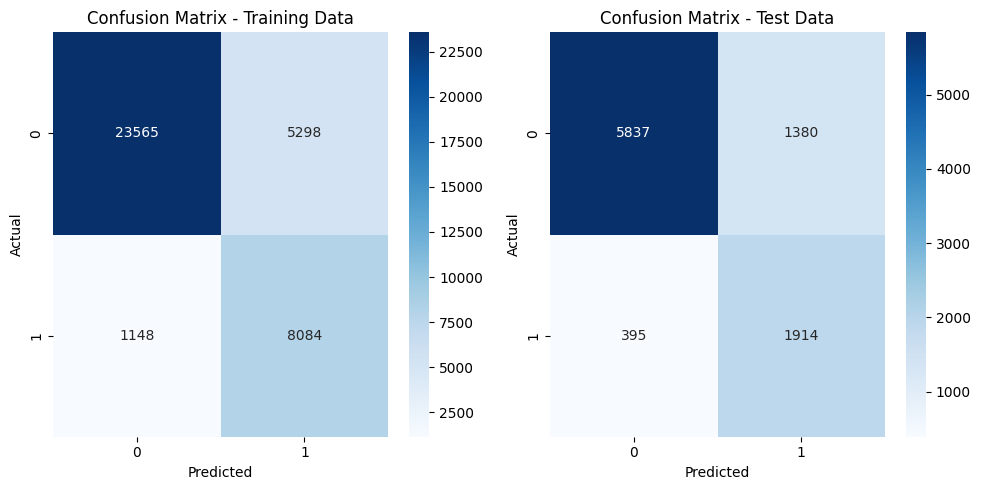

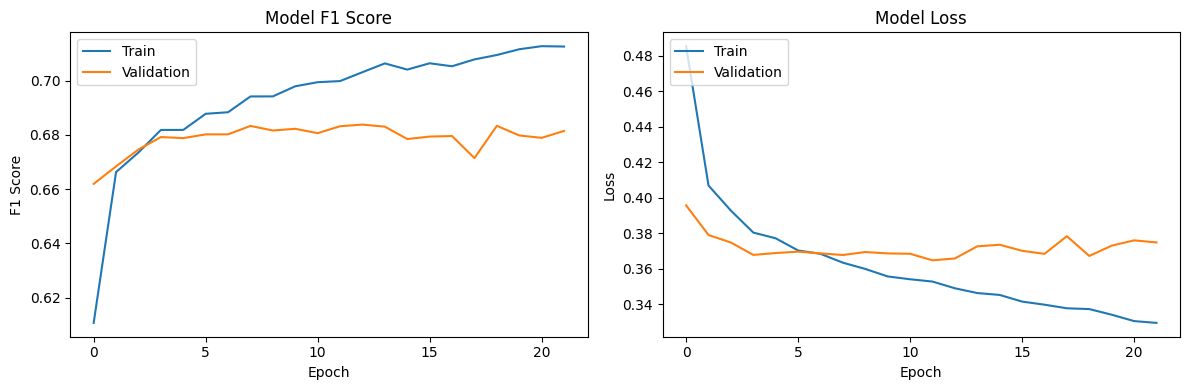

In [254]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping

# Import necessary libraries
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ensure that 'income' is the last column for convenience
df_train_encoded = df_train_encoded.copy()
df_test_encoded = df_test_encoded.copy()

# Extract features and target from df_train_encoded and df_test_encoded
X_train = df_train_encoded.drop(columns=['income']).values
y_train = df_train_encoded['income'].values
X_test = df_test_encoded.drop(columns=['income']).values
y_test = df_test_encoded['income'].values

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compute class weights to handle class imbalance
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    num_classes = len(classes)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
    return class_weights

# Compute weights for training labels
class_weight_dict = compute_class_weights(y_train)
print("Computed Class Weights:", class_weight_dict)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Test Precision:", results[2])
print("Test Recall:", results[3])

# Predict on test data
preds_test = model.predict(X_test)
preds_test_binary = np.round(preds_test)

# Compute F1 Score
f1_test = f1_score(y_test, preds_test_binary)
print("Test F1 Score:", f1_test)

# Predict on training data
preds_train = model.predict(X_train)
preds_train_binary = np.round(preds_train)

# Compute F1 Score on training data
f1_train = f1_score(y_train, preds_train_binary)
print("Train F1 Score:", f1_train)

# Confusion matrices
cm_train = confusion_matrix(y_train, preds_train_binary)
cm_test = confusion_matrix(y_test, preds_test_binary)

# Plot confusion matrices
plt.figure(figsize=(10, 5))

# Confusion Matrix for Training Data
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix for Test Data
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# Compute F1 score for training and validation sets per epoch
precision = history.history['Precision']
recall = history.history['Recall']
f1_score = 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + 1e-8)

precision_val = history.history['val_Precision']
recall_val = history.history['val_Recall']
f1_score_val = 2 * (np.array(precision_val) * np.array(recall_val)) / (np.array(precision_val) + np.array(recall_val) + 1e-8)


# Plot training & validation F1 score values
plt.figure(figsize=(12, 4))

# Plot training & validation F1 Score
plt.subplot(1, 2, 1)
plt.plot(f1_score)
plt.plot(f1_score_val)
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation Loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## load from not one hot and use the onehot function

In [241]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def prepend_col_name(df, columns):
    for col in columns:
        # print(type(col), col)
        df[col] = df[col].apply(lambda x: f"{col}_{x}")
    return df

def onehot(xtrain, xtest, categorical_columns, verbose=False):
  # copy so that the original data is not modified. 
  # if original data is modified, the rows values in train.csv and test.csv will have prepend column names
  xtrain_copy = xtrain.copy()
  xtest_copy = xtest.copy()

  # Prepend column names to train and test
  xtrain_copy = prepend_col_name(xtrain_copy, categorical_columns)
  xtest_copy = prepend_col_name(xtest_copy, categorical_columns)

  # Automatically determine the numerical columns
  numerical_cols = list(set(xtrain.columns) - set(categorical_columns))
  if verbose:
    print("xtrain shape: ", xtrain.shape)
    print("xtest shape: ", xtest.shape)
    print("Numerical columns: ", numerical_cols)

  # Prepare train_prep and test_prep
  xtrain_prep = xtrain[numerical_cols]
  xtest_prep = xtest[numerical_cols]

  # xtrain_prep.to_csv("xtrain_prep_ori.csv")

    # One-Hot Encoding with modified categorical values
  for col in categorical_columns:

      # One-Hot Encoding for xtrain_copy
      train_ohe = OneHotEncoder()
      train_ohe.set_output(transform="default") # Disable the pandas output to return an array because Pandas output does not support sparse data
      xtrain_onehot = train_ohe.fit_transform(xtrain_copy[col].values.reshape(-1,1))
      xtrain_onehot = xtrain_onehot.toarray()
      xtrain_onehot = pd.DataFrame(xtrain_onehot, columns = xtrain_copy[col].unique())

      xtrain_prep = pd.concat([xtrain_prep, xtrain_onehot], axis=1) # when dropping missing values, index won't be continuous, so concat (xtrain_prep, xtrain_onehot, axis=1) will not match

      # One-Hot Encoding for xtest_copy
      test_ohe = OneHotEncoder()
      test_ohe.set_output(transform="default") # Disable the pandas output to return an array because Pandas output does not support sparse data
      xtest_onehot = test_ohe.fit_transform(xtest_copy[col].values.reshape(-1,1))
      xtest_onehot = xtest_onehot.toarray()
      xtest_onehot = pd.DataFrame(xtest_onehot, columns = xtest_copy[col].unique())
      xtest_onehot = xtest_onehot.set_index(xtest_copy.index)
      xtest_prep = pd.concat([xtest_prep, xtest_onehot], axis=1)

      # Check differences between xtrain_copy and xtest_copy
      dif1 = set(xtest_copy[col].unique()) - set(xtrain_copy[col].unique())
      if dif1 != set():
        # safeguard 
        # make sure that the categorical values in xtest_copy are the same as in xtrain_copy
        error_message = f"""
        Differences found between xtest and xtrain in column: "{col}"
        Number of unique values in test (test - train): {len(dif1)}
        Unique values: {dif1}
        """
        raise TestTrainDiffError(error_message)

      if verbose:
        print(f"Differences between xtest and xtrain in column: {col}")
        print(len(dif1), dif1)

        
  return xtrain_prep, xtest_prep


In [240]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
# from .customErrors import TestTrainDiffError

def prepend_col_name(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: f"{col}_{x}")
    return df

def onehot_new(xtrain, xtest, categorical_columns, verbose=False):
    # Copy data to avoid modifying originals
    xtrain_copy = xtrain.copy()
    xtest_copy = xtest.copy()

    # Prepend column names to categorical values
    xtrain_copy = prepend_col_name(xtrain_copy, categorical_columns)
    xtest_copy = prepend_col_name(xtest_copy, categorical_columns)

    # Check for differences between train and test categories before encoding
    for col in categorical_columns:
        dif1 = set(xtest_copy[col].unique()) - set(xtrain_copy[col].unique())
        if dif1:
            error_message = f"""
            Differences found between xtest and xtrain in column: "{col}"
            Number of unique values in test (test - train): {len(dif1)}
            Unique values: {dif1}
            """
            raise TestTrainDiffError(error_message)

    # Apply OneHotEncoder to categorical columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(xtrain_copy[categorical_columns])

    # Transform both train and test sets
    xtrain_encoded = encoder.transform(xtrain_copy[categorical_columns])
    xtest_encoded = encoder.transform(xtest_copy[categorical_columns])

    # Create DataFrame for one-hot encoded columns
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    xtrain_onehot_df = pd.DataFrame(xtrain_encoded, columns=encoded_columns, index=xtrain_copy.index)
    xtest_onehot_df = pd.DataFrame(xtest_encoded, columns=encoded_columns, index=xtest_copy.index)

    # Concatenate numerical columns and one-hot encoded columns
    numerical_cols = list(set(xtrain.columns) - set(categorical_columns))
    xtrain_prep = pd.concat([xtrain[numerical_cols], xtrain_onehot_df], axis=1)
    xtest_prep = pd.concat([xtest[numerical_cols], xtest_onehot_df], axis=1)

    if verbose:
        print("xtrain_prep shape:", xtrain_prep.shape)
        print("xtest_prep shape:", xtest_prep.shape)

    return xtrain_prep, xtest_prep


In [250]:
train_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_train.csv")
test_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_test.csv")

categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']                    

train_df, test_df = onehot(train_df, test_df, categorical_vars, verbose=True)

print(train_df.shape)
print(test_df.shape)
df_train = train_df
df_test = test_df

print(df_train.shape)
print(df_test.shape)
print("before adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))
# Add missing columns to df_test
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0

# Ensure the columns are in the same order
df_test = df_test[df_train.columns]


print("after adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))


# Sort columns of train and test dataframes alphabetically
df_train = df_train.reindex(sorted(df_train.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)

print("Columns sorted alphabetically")
for i in range(len(df_train.columns)):
    if df_train.columns[i] != df_test.columns[i]:
        print("column difference")
        print(df_train.columns[i], df_test.columns[i])


xtrain shape:  (38095, 15)
xtest shape:  (9526, 15)
Numerical columns:  ['capital-loss', 'hours-per-week', 'age', 'education-num', 'fnlwgt', 'income', 'capital-gain']
Differences between xtest and xtrain in column: workclass
0 set()
Differences between xtest and xtrain in column: education
0 set()
Differences between xtest and xtrain in column: marital-status
0 set()
Differences between xtest and xtrain in column: occupation
0 set()
Differences between xtest and xtrain in column: relationship
0 set()
Differences between xtest and xtrain in column: race
0 set()
Differences between xtest and xtrain in column: sex
0 set()
Differences between xtest and xtrain in column: native-country
0 set()
(38095, 109)
(9526, 108)
(38095, 109)
(9526, 108)
before adding
train - test {'native-country_Holand-Netherlands'}
test - train set()
after adding
train - test set()
test - train set()
Columns sorted alphabetically


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - Precision: 0.4433 - Recall: 0.7513 - accuracy: 0.7113 - loss: 0.5427 - val_Precision: 0.5390 - val_Recall: 0.8450 - val_accuracy: 0.7872 - val_loss: 0.3945
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - Precision: 0.5362 - Recall: 0.8621 - accuracy: 0.7868 - loss: 0.4118 - val_Precision: 0.5506 - val_Recall: 0.8389 - val_accuracy: 0.7950 - val_loss: 0.3849
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - Precision: 0.5463 - Recall: 0.8672 - accuracy: 0.7942 - loss: 0.3968 - val_Precision: 0.5557 - val_Recall: 0.8424 - val_accuracy: 0.7986 - val_loss: 0.3780
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - Precision: 0.5563 - Recall: 0.8718 - accuracy: 0.8013 - loss: 0.3868 - val_Precision: 0.5479 - val_Recall: 0.8566 - val_accuracy: 0.7939 - val_loss: 0.3771
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - Precision: 0.5608 - Reca

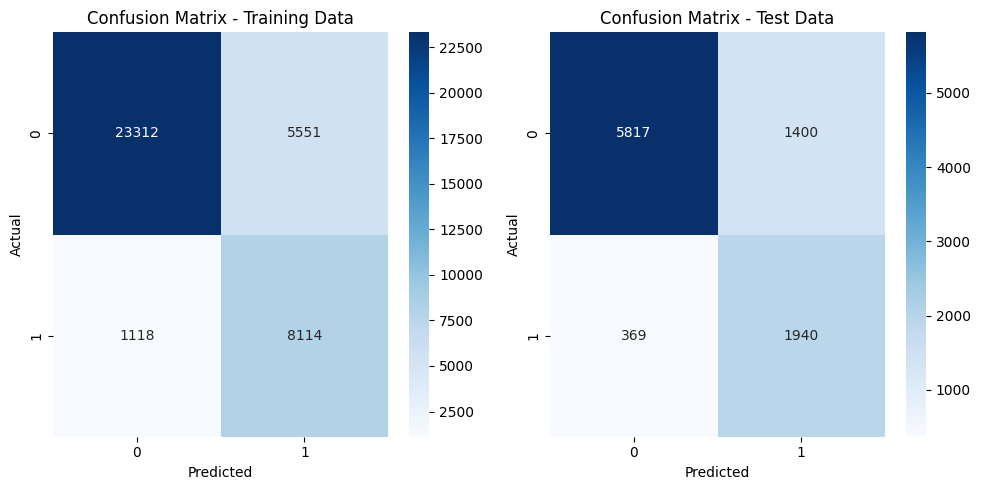

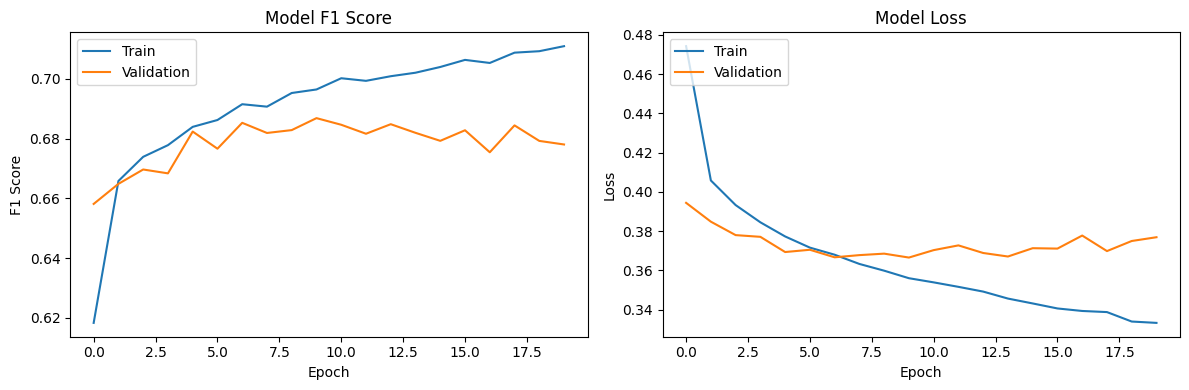

In [251]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
# Ensure that 'income' is the last column for convenience
# train_df = train_df.copy()
# test_df = test_df.copy()

train_df = df_train.copy()
test_df = df_test.copy()

# Extract features and target from train_df and test_df
X_train = train_df.drop(columns=['income']).values
y_train = train_df['income'].values
X_test = test_df.drop(columns=['income']).values
y_test = test_df['income'].values
import tensorflow as tf
from keras.callbacks import EarlyStopping

# Import necessary libraries
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ensure that 'income' is the last column for convenience
df_train_encoded = df_train_encoded.copy()
df_test_encoded = df_test_encoded.copy()

# Extract features and target from df_train_encoded and df_test_encoded
X_train = df_train_encoded.drop(columns=['income']).values
y_train = df_train_encoded['income'].values
X_test = df_test_encoded.drop(columns=['income']).values
y_test = df_test_encoded['income'].values

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compute class weights to handle class imbalance
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    num_classes = len(classes)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
    return class_weights

# Compute weights for training labels
class_weight_dict = compute_class_weights(y_train)
print("Computed Class Weights:", class_weight_dict)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Test Precision:", results[2])
print("Test Recall:", results[3])

# Predict on test data
preds_test = model.predict(X_test)
preds_test_binary = np.round(preds_test)

# Compute F1 Score
f1_test = f1_score(y_test, preds_test_binary)
print("Test F1 Score:", f1_test)

# Predict on training data
preds_train = model.predict(X_train)
preds_train_binary = np.round(preds_train)

# Compute F1 Score on training data
f1_train = f1_score(y_train, preds_train_binary)
print("Train F1 Score:", f1_train)

# Confusion matrices
cm_train = confusion_matrix(y_train, preds_train_binary)
cm_test = confusion_matrix(y_test, preds_test_binary)

# Plot confusion matrices
plt.figure(figsize=(10, 5))

# Confusion Matrix for Training Data
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix for Test Data
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# Compute F1 score for training and validation sets per epoch
precision = history.history['Precision']
recall = history.history['Recall']
f1_score = 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + 1e-8)

precision_val = history.history['val_Precision']
recall_val = history.history['val_Recall']
f1_score_val = 2 * (np.array(precision_val) * np.array(recall_val)) / (np.array(precision_val) + np.array(recall_val) + 1e-8)


# Plot training & validation F1 score values
plt.figure(figsize=(12, 4))

# Plot training & validation F1 Score
plt.subplot(1, 2, 1)
plt.plot(f1_score)
plt.plot(f1_score_val)
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation Loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [245]:
train_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_train.csv")
test_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_test.csv")

categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']                    

train_df, test_df = onehot_new(train_df, test_df, categorical_vars, verbose=True)

xtrain_prep shape: (38095, 109)
xtest_prep shape: (9526, 109)


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - Precision: 0.4355 - Recall: 0.7625 - accuracy: 0.6965 - loss: 0.5537 - val_Precision: 0.5647 - val_Recall: 0.8103 - val_accuracy: 0.8026 - val_loss: 0.3876
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - Precision: 0.5449 - Recall: 0.8566 - accuracy: 0.7928 - loss: 0.4124 - val_Precision: 0.5742 - val_Recall: 0.8125 - val_accuracy: 0.8085 - val_loss: 0.3710
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - Precision: 0.5550 - Recall: 0.8615 - accuracy: 0.7999 - loss: 0.3933 - val_Precision: 0.5753 - val_Recall: 0.8237 - val_accuracy: 0.8099 - val_loss: 0.3638
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - Precision: 0.5662 - Recall: 0.8658 - accuracy: 0.8075 - loss: 0.3866 - val_Precision: 0.5871 - val_Recall: 0.8216 - val_accuracy: 0.8167 - val_loss: 0.3607
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - Precision: 0.5646 - Reca

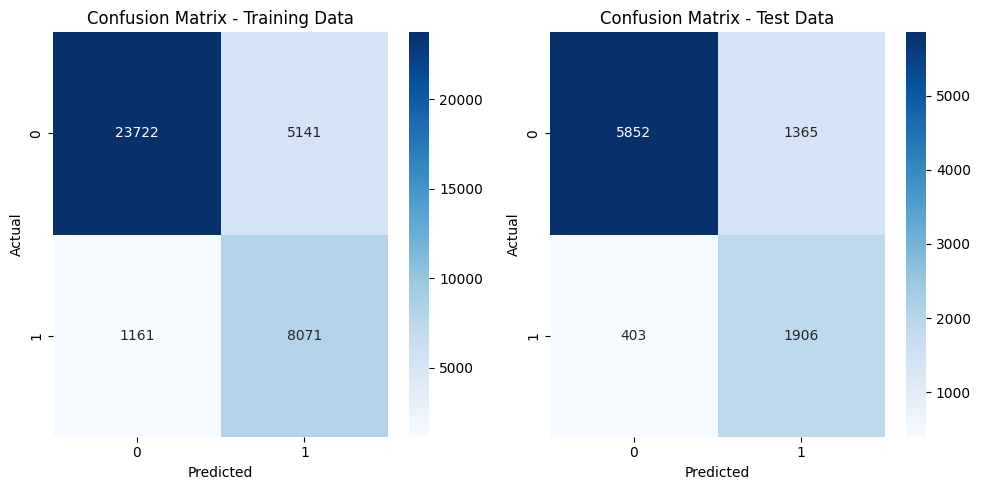

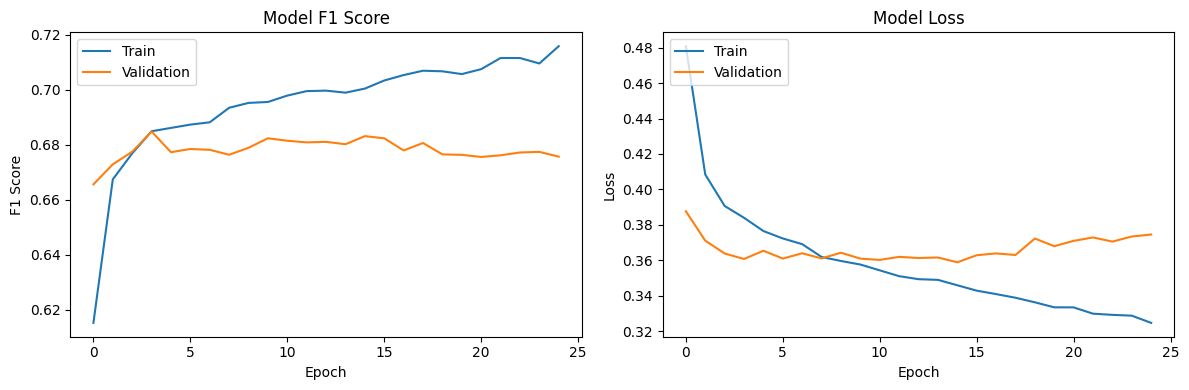

In [246]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
# Ensure that 'income' is the last column for convenience
# train_df = train_df.copy()
# test_df = test_df.copy()

train_df = df_train.copy()
test_df = df_test.copy()

# Extract features and target from train_df and test_df
X_train = train_df.drop(columns=['income']).values
y_train = train_df['income'].values
X_test = test_df.drop(columns=['income']).values
y_test = test_df['income'].values
import tensorflow as tf
from keras.callbacks import EarlyStopping

# Import necessary libraries
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ensure that 'income' is the last column for convenience
df_train_encoded = df_train_encoded.copy()
df_test_encoded = df_test_encoded.copy()

# Extract features and target from df_train_encoded and df_test_encoded
X_train = df_train_encoded.drop(columns=['income']).values
y_train = df_train_encoded['income'].values
X_test = df_test_encoded.drop(columns=['income']).values
y_test = df_test_encoded['income'].values

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compute class weights to handle class imbalance
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    num_classes = len(classes)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
    return class_weights

# Compute weights for training labels
class_weight_dict = compute_class_weights(y_train)
print("Computed Class Weights:", class_weight_dict)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Test Precision:", results[2])
print("Test Recall:", results[3])

# Predict on test data
preds_test = model.predict(X_test)
preds_test_binary = np.round(preds_test)

# Compute F1 Score
f1_test = f1_score(y_test, preds_test_binary)
print("Test F1 Score:", f1_test)

# Predict on training data
preds_train = model.predict(X_train)
preds_train_binary = np.round(preds_train)

# Compute F1 Score on training data
f1_train = f1_score(y_train, preds_train_binary)
print("Train F1 Score:", f1_train)

# Confusion matrices
cm_train = confusion_matrix(y_train, preds_train_binary)
cm_test = confusion_matrix(y_test, preds_test_binary)

# Plot confusion matrices
plt.figure(figsize=(10, 5))

# Confusion Matrix for Training Data
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix for Test Data
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# Compute F1 score for training and validation sets per epoch
precision = history.history['Precision']
recall = history.history['Recall']
f1_score = 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + 1e-8)

precision_val = history.history['val_Precision']
recall_val = history.history['val_Recall']
f1_score_val = 2 * (np.array(precision_val) * np.array(recall_val)) / (np.array(precision_val) + np.array(recall_val) + 1e-8)


# Plot training & validation F1 score values
plt.figure(figsize=(12, 4))

# Plot training & validation F1 Score
plt.subplot(1, 2, 1)
plt.plot(f1_score)
plt.plot(f1_score_val)
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation Loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()